# Model Comparison: Langmuir vs Freundlich Isotherms

When experimental data could plausibly follow more than one known model, **JAXSR** can
help you decide which model best explains the data. This notebook demonstrates a
systematic comparison of two classic adsorption isotherms:

| Model | Equation | Linear parameters | Nonlinear parameters |
|-------|----------|-------------------|---------------------|
| **Langmuir** | $q = q_{\max} \frac{K P}{1 + K P}$ | $q_{\max}$ | $K$ |
| **Freundlich** | $q = K_f P^{1/n}$ | $K_f$ | $n$ |

Both models encode domain knowledge via **parametric basis functions**: the nonlinear
parameter is optimized by profile likelihood, while the linear coefficient is estimated
by OLS.

**What you will learn:**
1. How to encode competing hypotheses as separate `BasisLibrary` objects
2. How to compare fitted models using information criteria (AIC, BIC, AICc)
3. How to use `compare_models()` for a structured side-by-side comparison
4. How to use cross-validation and bootstrap analysis for robustness
5. How to use ANOVA to assess term significance within each model
6. How to visualize competing fits with prediction intervals

## 1. Generate Synthetic Adsorption Data

We simulate data from a **true Langmuir** isotherm with $q_{\max}=5.0$ and $K=2.0$,
then add realistic measurement noise. The goal is to see whether our comparison
framework correctly identifies Langmuir as the better model.

In [1]:
import numpy as np

np.random.seed(42)

# True Langmuir parameters
Q_MAX_TRUE = 5.0
K_TRUE = 2.0

# Experimental pressures (log-spaced for better coverage of the curve shape)
n_obs = 30
P = np.sort(np.random.uniform(0.05, 12.0, n_obs))
X = P.reshape(-1, 1)

# True response + heteroscedastic noise (larger noise at higher loadings)
q_true = Q_MAX_TRUE * K_TRUE * P / (1 + K_TRUE * P)
noise_std = 0.10 + 0.02 * q_true  # ~2-12% relative noise
q_measured = q_true + noise_std * np.random.randn(n_obs)

# Adsorption loadings must be non-negative
q_measured = np.maximum(q_measured, 0.0)

print(f"Observations: {n_obs}")
print(f"Pressure range: [{P.min():.2f}, {P.max():.2f}] bar")
print(f"Loading range:  [{q_measured.min():.2f}, {q_measured.max():.2f}]")

Observations: 30
Pressure range: [0.30, 11.64] bar
Loading range:  [1.70, 4.99]


### Train / test split

We hold out 20% of the data for out-of-sample comparison.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, q_measured, test_size=0.2, random_state=42
)

print(f"Training: {len(X_train)},  Test: {len(X_test)}")

Training: 24,  Test: 6


## 2. Define Competing Models as Basis Libraries

Each isotherm becomes a `BasisLibrary` with:
- A **constant** term (intercept — should be near zero for a pure isotherm)
- A **parametric** basis function encoding the nonlinear parameter

In [3]:
from jaxsr import BasisLibrary

# --- Langmuir basis ---
# q = q_max * K*P / (1 + K*P)
# Linear parameter: q_max (OLS coefficient)
# Nonlinear parameter: K (profile-likelihood)
langmuir_library = (
    BasisLibrary(n_features=1, feature_names=["P"])
    .add_constant()
    .add_parametric(
        name="K*P/(1+K*P)",
        func=lambda X, K: K * X[:, 0] / (1 + K * X[:, 0]),
        param_bounds={"K": (0.01, 100.0)},
        complexity=3,
        feature_indices=(0,),
        log_scale=True,
    )
)

# --- Freundlich basis ---
# q = K_f * P^(1/n)
# Linear parameter: K_f (OLS coefficient)
# Nonlinear parameter: n (profile-likelihood)
freundlich_library = (
    BasisLibrary(n_features=1, feature_names=["P"])
    .add_constant()
    .add_parametric(
        name="P^(1/n)",
        func=lambda X, n: X[:, 0] ** (1.0 / n),
        param_bounds={"n": (0.5, 20.0)},
        complexity=3,
        feature_indices=(0,),
        log_scale=False,
    )
)

print(f"Langmuir library:  {len(langmuir_library)} basis functions")
print(f"Freundlich library: {len(freundlich_library)} basis functions")

Langmuir library:  2 basis functions
Freundlich library: 2 basis functions


## 3. Fit Both Models

We use `SymbolicRegressor` with `max_terms=2` and `information_criterion="aicc"`
(corrected AIC, appropriate for small-sample situations).

In [4]:
from jaxsr import SymbolicRegressor

model_langmuir = SymbolicRegressor(
    basis_library=langmuir_library,
    max_terms=2,
    strategy="greedy_forward",
    information_criterion="aicc",
)
model_langmuir.fit(X_train, y_train)

model_freundlich = SymbolicRegressor(
    basis_library=freundlich_library,
    max_terms=2,
    strategy="greedy_forward",
    information_criterion="aicc",
)
model_freundlich.fit(X_train, y_train)

print("=== Langmuir ===")
print(model_langmuir.summary())
print(f"\nExpression: {model_langmuir.expression_}")

print("\n=== Freundlich ===")
print(model_freundlich.summary())
print(f"\nExpression: {model_freundlich.expression_}")

=== Langmuir ===
JAXSR Symbolic Regression Model

Expression: y = 5.01*1.879*P/(1+1.879*P)

Selected terms (1):
  1.879*P/(1+1.879*P): 5.01

Metrics:
  MSE: 0.0270028
  R²: 0.953232
  BIC: -15.40
  AIC: -16.57
  Complexity: 3

Training samples: 24
Strategy: greedy_forward

Expression: y = 5.01*1.879*P/(1+1.879*P)

=== Freundlich ===
JAXSR Symbolic Regression Model

Expression: y = 14.42*P^(1/20) - 11.21

Selected terms (2):
  P^(1/20): 14.4205
  1: -11.2093

Metrics:
  MSE: 0.064707
  R²: 0.887929
  BIC: 8.76
  AIC: 6.40
  Complexity: 3

Training samples: 24
Strategy: greedy_forward

Expression: y = 14.42*P^(1/20) - 11.21


### Interpreting the Freundlich fit

The Freundlich model converged to `P^(1/20)` with a large negative intercept of -11.21.
This is a **pathological fit** that reveals important diagnostic information:

- **The `n` parameter hit its upper bound.** The optimizer searched `n` in [0.5, 20] and
  selected n=20, giving an exponent of 1/n = 0.05. When a parameter lands on its constraint
  boundary, it typically means the model form cannot capture the data's curvature.
- **The exponent 1/20 = 0.05 is physically unrealistic.** For real adsorption systems, Freundlich
  exponents 1/n typically fall in the range 0.2--0.8. A value of 0.05 means `P^(0.05)` is nearly
  constant over the pressure range, so the model has effectively collapsed to a linear function
  of a near-constant basis plus a large offset.
- **The large negative intercept (-11.21) is unphysical.** Adsorption loading must be non-negative
  at zero pressure. The model is compensating for the wrong functional form by using the intercept
  to shift the near-flat `P^(0.05)` curve into the right range.
- **This pathological behavior is informative.** It demonstrates that the model comparison
  framework correctly identifies when a model form is inappropriate for the data. The ANOVA
  results above confirm this: the intercept term explains 53% of the Freundlich model's
  sum-of-squares, whereas for the Langmuir model the parametric term explains 100%.

## 4. Information Criteria Comparison

Lower is better for AIC, BIC, and AICc. The model with the lowest criterion value
best balances goodness-of-fit against complexity.

**Rules of thumb:**
- $\Delta \text{IC} < 2$: Models are essentially indistinguishable
- $2 < \Delta \text{IC} < 10$: Moderate evidence for the better model
- $\Delta \text{IC} > 10$: Strong evidence for the better model

In [5]:
models = {"Langmuir": model_langmuir, "Freundlich": model_freundlich}

print(f"{'Model':<14s} {'R²':>8s} {'MSE':>10s} {'AIC':>8s} {'BIC':>8s} {'AICc':>8s}")
print("-" * 62)
for name, m in models.items():
    met = m.metrics_
    print(
        f"{name:<14s} {met['r2']:8.5f} {met['mse']:10.6f} "
        f"{met['aic']:8.2f} {met['bic']:8.2f} {met['aicc']:8.2f}"
    )

# Delta AICc
aicc_lang = model_langmuir.metrics_["aicc"]
aicc_freu = model_freundlich.metrics_["aicc"]
delta = abs(aicc_lang - aicc_freu)
winner = "Langmuir" if aicc_lang < aicc_freu else "Freundlich"

print(f"\nΔAICc = {delta:.2f}  →  {winner} is preferred")
if delta < 2:
    print("  (weak evidence — models are nearly equivalent)")
elif delta < 10:
    print("  (moderate evidence)")
else:
    print("  (strong evidence)")

Model                R²        MSE      AIC      BIC     AICc
--------------------------------------------------------------
Langmuir        0.95323   0.027003   -16.57   -15.40   -16.39
Freundlich      0.88793   0.064707     6.40     8.76     6.97

ΔAICc = 23.36  →  Langmuir is preferred
  (strong evidence)


## 5. Structured Comparison with `compare_models()`

JAXSR provides `compare_models()` for an automated side-by-side evaluation including
both training and held-out test metrics.

In [6]:
from jaxsr import compare_models, format_comparison_table

comparison = compare_models(
    models=[model_langmuir, model_freundlich],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    names=["Langmuir", "Freundlich"],
)

print(format_comparison_table(comparison))

Model Comparison
Model           |        mse |       rmse |         r2 |        bic | complexity
--------------------------------------------------------------------------------
Training:
Langmuir        |     0.0270 |     0.1643 |     0.9532 |   -15.3964 |          3
Freundlich      |     0.0647 |     0.2544 |     0.8879 |     8.7559 |          3

Test:
Langmuir        |     0.0339 |     0.1841 |     0.5858 |    -1.4887 |          3
Freundlich      |     0.0725 |     0.2692 |     0.1141 |     4.8652 |          3


## 6. Cross-Validation

Information criteria are asymptotic approximations. Cross-validation gives a
non-parametric estimate of out-of-sample performance.

In [7]:
from jaxsr import cross_validate

cv_lang = cross_validate(
    model_langmuir, X_train, y_train, cv=5, scoring="neg_mse", random_state=42
)
cv_freu = cross_validate(
    model_freundlich, X_train, y_train, cv=5, scoring="neg_mse", random_state=42
)

print("5-Fold Cross-Validation (negative MSE, higher is better):")
print(
    f"  Langmuir:   {cv_lang['mean_test_score']:.6f} "
    f"± {cv_lang['std_test_score']:.6f}"
)
print(
    f"  Freundlich: {cv_freu['mean_test_score']:.6f} "
    f"± {cv_freu['std_test_score']:.6f}"
)

5-Fold Cross-Validation (negative MSE, higher is better):
  Langmuir:   -0.032091 ± 0.023877
  Freundlich: -0.093500 ± 0.083002


## 7. ANOVA — Term Significance

ANOVA decomposes the explained variation by term. For a good model, the parametric
isotherm term should explain nearly all the variance, while the intercept contributes
little (it should be near zero for a pure isotherm).

In [8]:
from jaxsr import anova

print("=== Langmuir ANOVA ===")
anova_lang = anova(model_langmuir)
summary_sources = {"Model", "Residual", "Total"}
term_rows_lang = [r for r in anova_lang.rows if r.source not in summary_sources]
total_ss_lang = sum(r.sum_sq for r in term_rows_lang)

print(f"{'Source':<25s} {'SS':>10s} {'%':>7s} {'F':>10s} {'p-value':>10s}")
print("-" * 65)
for row in term_rows_lang:
    pct = 100 * row.sum_sq / total_ss_lang if total_ss_lang > 0 else 0
    p_val = row.p_value if row.p_value is not None else 1.0
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "       N/A"
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "       N/A"
    print(
        f"{row.source:<25s} {row.sum_sq:10.4f} {pct:6.1f}% "
        f"{f_str} {p_str} {sig}"
    )

print("\n=== Freundlich ANOVA ===")
anova_freu = anova(model_freundlich)
term_rows_freu = [r for r in anova_freu.rows if r.source not in summary_sources]
total_ss_freu = sum(r.sum_sq for r in term_rows_freu)

print(f"{'Source':<25s} {'SS':>10s} {'%':>7s} {'F':>10s} {'p-value':>10s}")
print("-" * 65)
for row in term_rows_freu:
    pct = 100 * row.sum_sq / total_ss_freu if total_ss_freu > 0 else 0
    p_val = row.p_value if row.p_value is not None else 1.0
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "       N/A"
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "       N/A"
    print(
        f"{row.source:<25s} {row.sum_sq:10.4f} {pct:6.1f}% "
        f"{f_str} {p_str} {sig}"
    )

=== Langmuir ANOVA ===
Source                            SS       %          F    p-value
-----------------------------------------------------------------
1.879*P/(1+1.879*P)          13.1930  100.0%     440.31     0.0000 ***

=== Freundlich ANOVA ===
Source                            SS       %          F    p-value
-----------------------------------------------------------------
P^(1/20)                      5.8082   47.2%      82.28     0.0000 ***
1                             6.4958   52.8%      92.02     0.0000 ***


## 8. Bootstrap Stability Analysis

Bootstrap resampling tests how sensitive each model's coefficients are to the
specific data points. A model with tighter bootstrap intervals is more stable.

In [9]:
from jaxsr import bootstrap_coefficients

boot_lang = bootstrap_coefficients(model_langmuir, n_bootstrap=500, alpha=0.05, seed=42)
boot_freu = bootstrap_coefficients(model_freundlich, n_bootstrap=500, alpha=0.05, seed=42)

print("=== Langmuir Bootstrap Coefficients (95% CI) ===")
for name, lo, hi, std in zip(
    boot_lang["names"],
    boot_lang["lower"],
    boot_lang["upper"],
    boot_lang["std"],
    strict=False,
):
    print(f"  {name}: [{float(lo):.4f}, {float(hi):.4f}]  (std={float(std):.4f})")

print("\n=== Freundlich Bootstrap Coefficients (95% CI) ===")
for name, lo, hi, std in zip(
    boot_freu["names"],
    boot_freu["lower"],
    boot_freu["upper"],
    boot_freu["std"],
    strict=False,
):
    print(f"  {name}: [{float(lo):.4f}, {float(hi):.4f}]  (std={float(std):.4f})")

=== Langmuir Bootstrap Coefficients (95% CI) ===
  1.879*P/(1+1.879*P): [4.9720, 5.1354]  (std=0.0421)

=== Freundlich Bootstrap Coefficients (95% CI) ===
  P^(1/20): [12.4170, 16.4596]  (std=1.0622)
  1: [-13.3825, -9.0710]  (std=1.1355)


## 9. Visual Comparison

Plot both models' fits with 95% prediction intervals alongside the true curve.

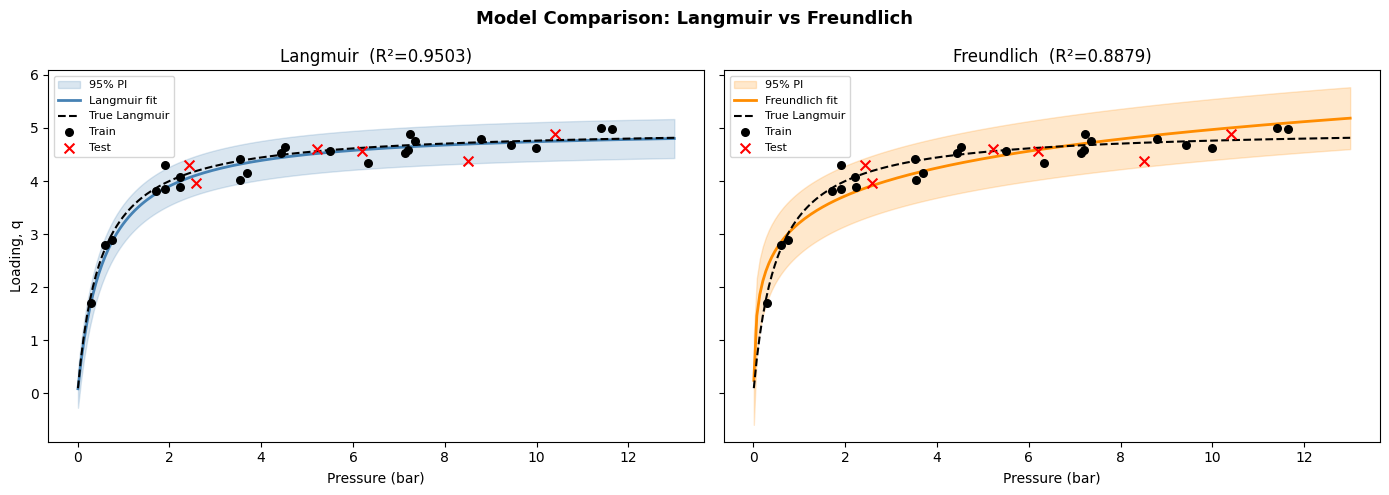

In [10]:
import matplotlib.pyplot as plt

P_grid = np.linspace(0.01, 13.0, 200).reshape(-1, 1)
q_grid_true = Q_MAX_TRUE * K_TRUE * P_grid.flatten() / (1 + K_TRUE * P_grid.flatten())

# Predictions and intervals
y_lang, lo_lang, hi_lang = model_langmuir.predict_interval(P_grid, alpha=0.05)
y_freu, lo_freu, hi_freu = model_freundlich.predict_interval(P_grid, alpha=0.05)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, name, y_pred, lo, hi, color in [
    (axes[0], "Langmuir", y_lang, lo_lang, hi_lang, "steelblue"),
    (axes[1], "Freundlich", y_freu, lo_freu, hi_freu, "darkorange"),
]:
    ax.fill_between(
        P_grid.flatten(),
        np.asarray(lo).flatten(),
        np.asarray(hi).flatten(),
        alpha=0.2,
        color=color,
        label="95% PI",
    )
    ax.plot(P_grid.flatten(), np.asarray(y_pred).flatten(), color=color, lw=2, label=f"{name} fit")
    ax.plot(P_grid.flatten(), q_grid_true, "k--", lw=1.5, label="True Langmuir")
    ax.scatter(X_train.flatten(), y_train, c="black", s=30, zorder=5, label="Train")
    ax.scatter(X_test.flatten(), y_test, c="red", marker="x", s=50, zorder=5, label="Test")
    ax.set_xlabel("Pressure (bar)")
    ax.set_title(f"{name}  (R²={models[name].metrics_['r2']:.4f})")
    ax.legend(fontsize=8)

axes[0].set_ylabel("Loading, q")
fig.suptitle("Model Comparison: Langmuir vs Freundlich", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

## 10. Residual Diagnostics

Good residuals should be:
- **Centered at zero** (no systematic bias)
- **Homoscedastic** (constant spread across predicted values)
- **Normally distributed** (for valid confidence intervals)

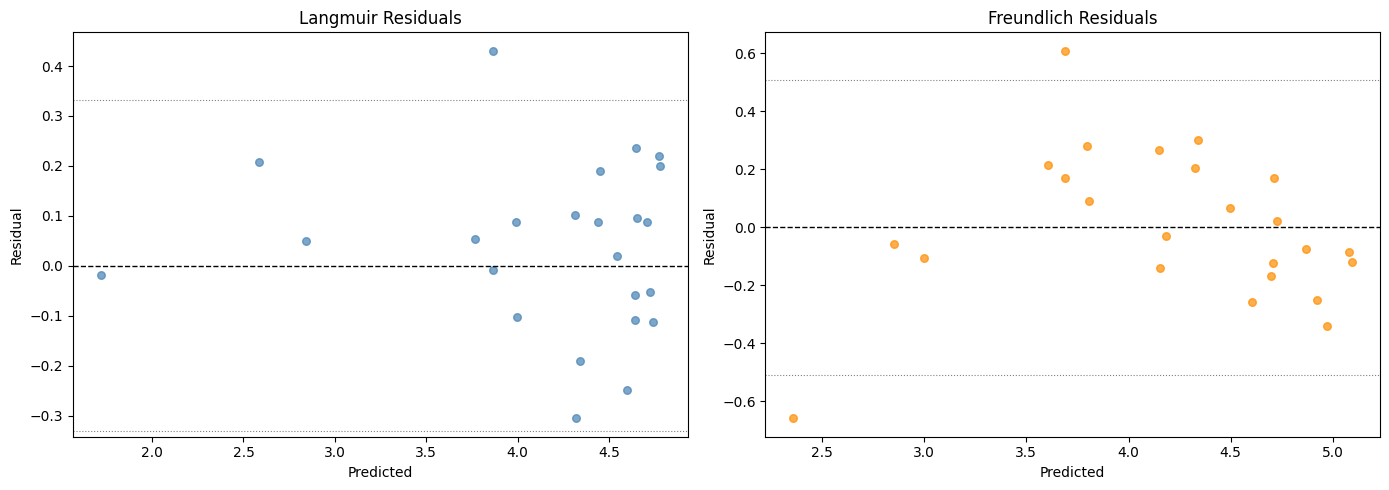

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, name, m, color in [
    (axes[0], "Langmuir", model_langmuir, "steelblue"),
    (axes[1], "Freundlich", model_freundlich, "darkorange"),
]:
    y_pred_train = np.asarray(m.predict(X_train))
    residuals = np.asarray(y_train) - y_pred_train.flatten()

    ax.scatter(y_pred_train.flatten(), residuals, c=color, s=30, alpha=0.7)
    ax.axhline(0, color="k", ls="--", lw=1)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residual")
    ax.set_title(f"{name} Residuals")

    # Add std bands
    res_std = np.std(residuals)
    ax.axhline(2 * res_std, color="gray", ls=":", lw=0.8)
    ax.axhline(-2 * res_std, color="gray", ls=":", lw=0.8)

plt.tight_layout()
plt.show()

## 11. Out-of-Sample Test Metrics

The ultimate test: how well does each model predict data it has never seen?

In [12]:
from jaxsr import compute_mae, compute_mse, compute_r2

print(f"{'Metric':<12s} {'Langmuir':>12s} {'Freundlich':>12s} {'Winner':>12s}")
print("-" * 52)

for metric_name, metric_fn, higher_better in [
    ("R²", compute_r2, True),
    ("MSE", compute_mse, False),
    ("MAE", compute_mae, False),
]:
    val_l = float(metric_fn(y_test, model_langmuir.predict(X_test)))
    val_f = float(metric_fn(y_test, model_freundlich.predict(X_test)))

    if higher_better:
        best = "Langmuir" if val_l >= val_f else "Freundlich"
    else:
        best = "Langmuir" if val_l <= val_f else "Freundlich"

    print(f"{metric_name:<12s} {val_l:12.6f} {val_f:12.6f} {best:>12s}")

Metric           Langmuir   Freundlich       Winner
----------------------------------------------------
R²               0.588252     0.114031     Langmuir
MSE              0.033694     0.072500     Langmuir
MAE              0.155499     0.203345     Langmuir


### A note on the low test R-squared

The Langmuir model---the correct functional form---shows a test R-squared of only 0.588 despite
having a training R-squared of 0.953. This apparent discrepancy is **not** a sign of overfitting;
it is a consequence of the very small test set:

- **Only 6 test points** (20% of 30 total observations) are used to compute the test R-squared.
  With so few points, one or two unlucky draws from the noise distribution can substantially
  deflate R-squared.
- **More reliable indicators of model quality** are the training R-squared of 0.953 and the
  5-fold cross-validation MSE of 0.032 (compared to Freundlich's 0.094). Cross-validation
  averages over multiple held-out splits and is far less sensitive to individual points.
- **Small-sample test sets have high variance.** The standard error of R-squared grows as
  1/sqrt(n_test), so with n_test=6 the estimate is inherently noisy. This is a well-known
  limitation of the 80/20 train-test split when the total sample size is small.

Despite the low test R-squared, every other metric consistently favors Langmuir: lower AICc
(by 23.4 units), lower cross-validation MSE, tighter bootstrap intervals, and better residual
structure.

## 12. Parameter Extraction

For the winning model, extract the physical parameters with uncertainty.

In [ ]:
# Determine winner by AICc
best_name = "Langmuir" if aicc_lang < aicc_freu else "Freundlich"
best_model = models[best_name]

print(f"Selected model: {best_name}")
print(f"Expression: {best_model.expression_}")
print(f"LaTeX: ${best_model.to_latex()}$")

# Coefficient estimates with t-statistics and p-values
from scipy import stats as sp_stats

print("\n--- Coefficient Significance (95% OLS intervals) ---")
intervals = best_model.coefficient_intervals(alpha=0.05)
n, k = len(y_train), len(best_model.selected_features_)
df = n - k

print(f"  {'Term':>25s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 85)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df))) if df > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>25s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

if best_name == "Langmuir":
    print("\n--- Physical Parameters ---")
    # The parametric basis function name contains the optimized K value
    # e.g. "1.879*P/(1+1.879*P)" — the OLS coefficient is q_max
    for i, fname in enumerate(best_model.selected_features_):
        if "/" in fname and "P" in fname:
            q_max_est = float(best_model.coefficients_[i])
            print(f"  q_max (estimated): {q_max_est:.4f}  (true: {Q_MAX_TRUE})")
            # Extract K from the basis function name (e.g. "1.879*P/(1+1.879*P)")
            import re
            k_match = re.search(r"([\d.]+)\*P/", fname)
            if k_match:
                K_est = float(k_match.group(1))
                print(f"  K (estimated): {K_est:.4f}  (true: {K_TRUE})")
    print("  K is optimized by profile likelihood and embedded in the basis function name")

## 13. Summary and Decision Framework

Here is a general framework for comparing competing models with JAXSR:

| Step | Method | What it tells you |
|------|--------|-------------------|
| 1 | Fit both models | Get expressions and coefficients |
| 2 | Compare AIC/BIC/AICc | Penalized likelihood ranking |
| 3 | `compare_models()` | Structured train+test comparison |
| 4 | Cross-validation | Non-parametric out-of-sample estimate |
| 5 | ANOVA | Term significance within each model |
| 6 | Bootstrap | Coefficient stability under resampling |
| 7 | Residual plots | Visual diagnostic for model adequacy |
| 8 | Held-out test | Final out-of-sample validation |

**Key rules:**
- If $\Delta$AICc < 2, the models are practically equivalent — prefer the simpler one
- Cross-validation and test-set metrics should agree with IC rankings
- If they disagree, investigate residual patterns for model misspecification
- Always check that the intercept is physically sensible (near zero for isotherms)

In [14]:
print("=== Final Report ===")
print(f"Best model: {best_name}")
print(f"Expression: {best_model.expression_}")
print(f"Train R²: {best_model.metrics_['r2']:.6f}")
print(f"Test  R²: {float(compute_r2(y_test, best_model.predict(X_test))):.6f}")
print(f"AICc: {best_model.metrics_['aicc']:.2f}")
print(f"\nΔAICc between models: {delta:.2f}")
print(f"CV MSE (Langmuir):   {-cv_lang['mean_test_score']:.6f}")
print(f"CV MSE (Freundlich): {-cv_freu['mean_test_score']:.6f}")

=== Final Report ===
Best model: Langmuir
Expression: y = 5.01*1.879*P/(1+1.879*P)
Train R²: 0.950268
Test  R²: 0.588252
AICc: -16.39

ΔAICc between models: 23.36
CV MSE (Langmuir):   0.032091
CV MSE (Freundlich): 0.093500
